In [131]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from astropy.convolution import convolve
import scipy.stats
from tqdm import tqdm
from skimage.restoration import denoise_tv_bregman
from numpy.linalg import norm
import scipy
import bm3d

In [130]:
pip install bm3d

     ---------------------------------------- 1.1/1.1 MB 663.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
def interpolate_nn(data: np.array) -> np.array:
    """
    Function to fill nan values in a 2D array using nearest neighbor
    interpolation.

    Source: https://stackoverflow.com/a/27745627
    """
    ind = nd.distance_transform_edt(np.isnan(data),
                                    return_distances=False,
                                    return_indices=True)
    return data[tuple(ind)]


In [105]:
def get_enl_img(img: np.ndarray,
                window_size: int,
                enl_max: int = 20,
                mask: np.ndarray = None) -> np.ndarray:
    """
    This is the simplest way to to estimate the ENL i.e the Effective Number of
    Looks. Let E and V be the expected value and variance within a window
    determined by the `window_size`. Then enl computes the per-pixel ENL
    as E^2 / V.

    There are numerous related and more sophisticated methods discussed in
    Zhao's thesis [2].

    What's great is that astropy (used in this function) deals with np.nan
    values by interpolating across them on the fly quickly. This is extremely
    effective.

    Source:

    [1] https://github.com/WeiyingZhao/Multitemporal-SAR-image-denoising
    [2] https://www.theses.fr/2019SACLT003

    Parameters
    ----------
    img : np.ndarray
        The backscatter image. Assume that np.nan is nodata. If mask is
        specified additionally, then it generates a new image with nodata areas
        with values np.nan.
    window_size : int
        The `n x n` window. Must be odd (otherwise astropy)
        will throw an error.
    enl_max : int
        The maximum value allowed during binning.
        We clip the value after the computation.
    mask : np.ndarray
        The mask to ignore with True indicating areas to ignore.

    Returns
    -------
    np.ndarray:
        The ENL per-pixel image
    """
    if mask is not None:
        img_ = img.copy()
        img_[mask] = np.nan
    else:
        img_ = img

    kernel = np.ones((window_size, window_size))

    img_mean = convolve(img_,
                        kernel,
                        boundary='extend',
                        nan_treatment='interpolate',
                        normalize_kernel=True,
                        preserve_nan=True)
    img_sqr_mean = convolve(img_**2,
                            kernel,
                            normalize_kernel=True,
                            boundary='extend',
                            nan_treatment='interpolate',
                            preserve_nan=True)
    img_variance = img_sqr_mean - img_mean**2

    enl_img = img_mean**2 / np.clip(img_variance, .0001, 1./enl_max)
    enl_img = np.clip(enl_img, 0, enl_max)

    return enl_img


def get_enl_mode(enl_img: np.ndarray,
                 enl_min: int = 1,
                 enl_max: int = 20) -> float:
    """
    Put `enl_img` image into bins from enl_min, ... enl_max with intervals of
    .1 to find the maximum bin. Usually has one peak, but may wish to view the
    histogram.

    Parameters
    ----------
    enl_img : np.ndarray
        The image of per-pixel enl. Use the routine `get_enl_img`.
    enl_min : int
        The bottommost bin; must be greater than 1. Default is 1.
    enl_max : int
        The expected top most bin. Default is 20.

    Returns
    -------
    Float:
       The enl mode from the .1 bin.
    """
    if enl_min < 1:
        raise ValueError('enl_min must be > 1')

    data_ = enl_img[~np.isnan(enl_img)]

    int_max = int(np.ceil(data_.max()))
    data_max = min(int_max, enl_max)
    n_bins = (data_max - enl_min) * 10 + 1
    bins = np.linspace(enl_min, data_max, n_bins)

    result = scipy.stats.binned_statistic(data_,
                                          data_,
                                          statistic='count',
                                          bins=bins)
    counts = result.statistic
    return bins[np.argmax(counts)]


def get_enl_mask(img: np.ndarray,
                 db_min: float = -18,
                 additional_mask: np.ndarray = None) -> np.ndarray:
    """
    This is to generate a mask for ENL computations. Generally, ignore pixels
    within image (assumed to be linear scale) below db_min and additional_mask
    is one that can be included to further concentrate ENL estimates.

    Parameters
    ----------
    img : np.ndarray
        The linear-scale basckatter image to generate a mask from.
    db_min : float
        The db value to ignore pixels below this threshold.
    additional_mask : np.ndarray
        This is an additional mask in which True is nodata.

     Returns
    -------
    np.ndarray:
        The ENL mask with True = Nodata area and False = Data Areas.
    """
    nodata_mask = np.isnan(img)
    db_img = 10 * np.log10(img.astype(np.float64)+1e-10,
                           where=~nodata_mask,
                           out=np.ones(img.shape, dtype=np.float64)*-9999
                           )
    system_noise_mask = (db_img < db_min)
    enl_mask = system_noise_mask | nodata_mask
    if additional_mask is not None:
        enl_mask = enl_mask | additional_mask
    return enl_mask

In [18]:
def admm_ratio_denoise(img: np.ndarray,
                       L: float,
                       Lm: float,
                       regularizer: str,
                       regularizer_params: dict = None,
                       max_admm_iterations: int = 10,
                       newton_iterations: int = 3,
                       denoiser_iterations: int = 10,
                       x_init: np.ndarray = None,
                       convergence_crit: float = 1e-5) -> np.ndarray:
    """
    We u
    se the variables using Boyd's ADMM review article in [1].

    This is essentially the same implementation as the `admm_spatial_denoise`
    in `spatial_denoise.py` save for the likelihood function used for the noise
    model as noted in the Rabasar paper [2] and some initialization. It may be
    good to combine them using the common implementations, but for clarity we
    leave them separat.

    [1] https://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf
    [2] https://hal.archives-ouvertes.fr/hal-01791355v2

    Parameters
    ----------
    img : np.ndarray
        The ratio image. The image is I / I_ta, where I is the image in the
        time series and I_ta is the temporally averaged reference.
    L : float
        This is the ENL for img in the numerator.
    Lm: float
        This is the ENL of the temporally averaged reference image in the
        denominator of the ratio.
    regularizer : str
        The string identifier for the regularizer. The accepted values are `tv`
        and `bm3d`.
    regularizer_params : dict
        For `tv`:
            + {
                'weight': weight (float)
              }
        For `bm3d`:
            + {
                'weight': weight (float)
              }
        If you wanted to add more keyword arguments to the denoiser, this would
        be the place to do so. It would be easy, for example, to update this
        function so that all the possible arguments of the `bregman_tv_denoise`
        of skimage were available to control by the user.
    max_admm_iterations : int
        The maximum number of iterations. Default = 10.
    newton_iterations : int
        Maximum number of newton iterations per ADMM loop. Default = 3.
    denoiser_iterations : int
        The number of denoiser iterations (if applicable). Default = 10.
    convergence_crit : float
        The value for the sum of the residuals to be smaller than and to stop
        ADMM. Default = 1e-5

    Returns
    -------
    np.array:
       Denoised Image
    """

    eta = 0.95
    gamma = 1.05
    block_diff = block_diff_old = np.inf
    block_diff_list = []

    # Log
    img_db = np.log10(img)

    # see:
    # https://github.com/WeiyingZhao/Multitemporal-SAR-image-denoising/blob/master/rulog.m#L114
    # the original paper references pg. 4 of Mulog paper.
    var = float(scipy.special.polygamma(1, L))
    beta = (1 + 2/L + 2/Lm) / var

    ################
    # Denoiser Setup
    ################

    if regularizer == 'tv':
        lamb_param = regularizer_params['weight']
        isotropic = regularizer_params.get('isotropic', True)

        def denoiser(X, lamb):
            return denoise_tv_bregman(X,
                                      lamb,
                                      max_iter=denoiser_iterations,
                                      isotropic=isotropic)
    elif regularizer == 'bm3d':
        lamb_param = regularizer_params['weight']

        def denoiser(X, lamb):
            return bm3d.bm3d(X, lamb)
    else:
        pass

    ###############################
    # Begin Plug and Play ADMM Loop
    ###############################

    if x_init is None:
        x_k = img_db.copy()
    else:
        x_k = x_init.copy()
    z_k = denoiser(x_k, lamb_param)
    u_k = z_k - x_k

    for k in tqdm(range(max_admm_iterations), desc='admm_iterations'):

        z_kp1 = denoiser(x_k - u_k, (lamb_param * beta))
        u_kp1 = u_k + z_kp1 - x_k

        x_kp1 = x_k.copy()
        for i in range(newton_iterations):
            x_kp1 = ratio_lklhd_iter(x_kp1, z_kp1 + u_kp1, img_db, L, Lm, beta)

        # Not sure about this, but plug and play?
        block_diff = (norm(x_k - x_kp1) +
                      norm(u_k - u_kp1) +
                      norm(z_k - z_kp1)
                      )
        if block_diff > eta * block_diff_old:
            beta = gamma * beta
        z_k = z_kp1
        u_k = u_kp1
        x_k = x_kp1
        block_diff_old = block_diff
        block_diff_list.append(block_diff)

        if block_diff < convergence_crit:
            break

    return np.power(10, x_k), block_diff_list


def ratio_lklhd_iter(x_k, a_k, img, L, Lm, beta):
    exp_diff = np.exp(img - x_k)
    c = (Lm + L) * exp_diff / (Lm + L * exp_diff)
    numer = beta * (x_k - a_k) + L * (1 - c)
    denom = beta + L * c * (1 - L / (Lm + L) * c)
    x_kp1 = x_k - numer / denom
    return x_kp1

In [19]:
filename_out = "S1A_IW_SLC__1SDV_20170103T015004_20170103T015030_014661_017D92_6421_Orb_Stack.tif"

image = tifffile.imread(filename_out)

image_1 = image[0,:,:] + 1j*image[1,:,:]

image_2 = image[1,:,:] + 1j*image[2,:,:]

image_3 = image[2,:,:] + 1j*image[3,:,:]

(8054-1786j)
dimensions de l'image:  (3008, 24639)


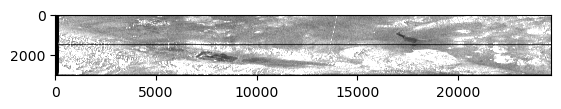

In [20]:
#Affichage de l'image 1

print(np.max(image_1))
print ("dimensions de l'image: ",np.shape (image_1) )
plt.subplot(2,1,1)
plt.imshow(np.abs(image_1),cmap="gray",vmax= 1/220* np.max(np.abs(image_1)))
plt.show()


(16757+0j)
[[ 0.+0.j  0.+0.j  0.+0.j ... -6.+0.j -4.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  2.+0.j  2.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  3.+0.j  4.+0.j  3.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j  1.+0.j  2.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  2.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j  0.+0.j  0.+0.j]]
dimensions de la seconde image:  (3008, 24639)


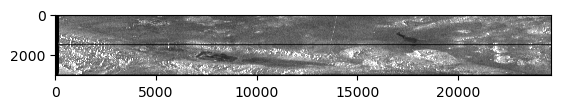

In [21]:
#Affichage de l'image 2

print(np.max(image_2))
print ( image_2 )
print ("dimensions de la seconde image: ",np.shape (image_2) )
plt.subplot(2,1,1)
plt.imshow(np.abs(image_2),cmap="gray",vmax= 1/220* np.max(np.abs(image_2)))
plt.show()

0j
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
dimensions de l'image:  (3008, 24639)


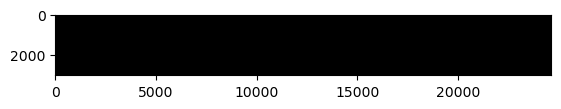

In [8]:
#Affichage de l'image 3

print(np.max(image_3))
print ( image_3 )
print ("dimensions de l'image: ",np.shape (image_3) )
plt.subplot(2,1,1)
plt.imshow(np.abs(image_3),cmap="gray",vmax= 1/220* np.max(np.abs(image_3)))
plt.show()

C'est bizarre que tous les valeurs de la troisième image soient nulles 


# Configuration

# Specification de la zone de pixels  

In [69]:
sy = np.s_[-1500:-1000] 
sx = np.s_[-3000:-1000]
def slice (image):
    # Use the slices to extract subarrays
    subarray_y = image[sy]  # Extracts elements from index -2000 to -1000
    subarray_x = image[sx]  # Extracts elements from index -3000 to -2000
    return subarray_x, subarray_y

In [60]:
subarray_x, subarray_y = slice (image_1)
print (subarray_x)
print ("la zone de pixels sélectionnée est:", np.shape(subarray_x) )

[[  0. +0.j   0. +0.j   0. +0.j ...   6. +5.j   6. +2.j   2. +0.j]
 [  0. +0.j   0. +0.j   0. +0.j ...  -2. +5.j  -1. +1.j   0. -1.j]
 [  0. +0.j   0. +0.j   0. +0.j ...   2. -4.j   0. -6.j   0. -3.j]
 ...
 [  0. +0.j   0. +0.j   0. +0.j ...  13.+38.j -39.+75.j -70.+41.j]
 [  0. +0.j   0. +0.j   0. +0.j ... -34. -7.j  10. -5.j  37. +6.j]
 [  0. +0.j   0. +0.j   0. +0.j ... -13. -9.j  -2.+27.j  -7. -2.j]]
la zone de pixels sélectionnée est: (2000, 24639)


In [61]:
subarray_x2, subarray_y2 = slice (image_2)
print (subarray_x2)
print (subarray_y2)


[[ 0.+0.j  0.+0.j  0.+0.j ...  5.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  5.+0.j  1.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -4.+0.j -6.+0.j -3.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... 38.+0.j 75.+0.j 41.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -7.+0.j -5.+0.j  6.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -9.+0.j 27.+0.j -2.+0.j]]
[[ 0.+0.j  0.+0.j  0.+0.j ... -3.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -2.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j -1.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... 38.+0.j 75.+0.j 41.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -7.+0.j -5.+0.j  6.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -9.+0.j 27.+0.j -2.+0.j]]


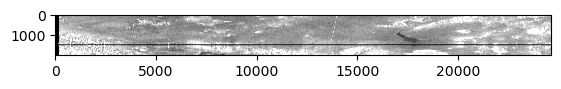

In [62]:
plt.imshow(np.abs(subarray_x),cmap="gray",vmax= 1/220* np.max(np.abs(subarray_x)))
plt.show()

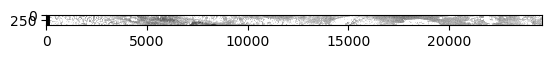

In [64]:
plt.imshow(np.abs(subarray_y),cmap="gray",vmax= 1/220* np.max(np.abs(subarray_y)))
plt.show()

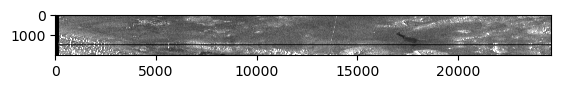

In [52]:
plt.imshow(np.abs(subarray_x2),cmap="gray",vmax= 1/220* np.max(np.abs(subarray_x2)))
plt.show()

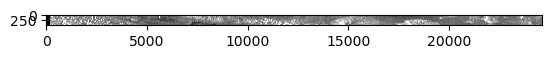

In [65]:
plt.imshow(np.abs(subarray_y2),cmap="gray",vmax= 1/220* np.max(np.abs(subarray_y2)))
plt.show()

In [81]:
sy2 = np.s_[-1500:-1000] 
sx2 = np.s_[-1500:-1000]
img1 = image_1[sy2, sx2]

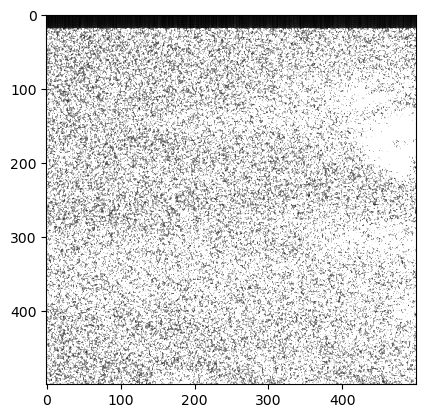

In [84]:
plt.imshow(np.abs(img1),cmap="gray",vmax= 1/11* np.max(np.abs(img1)))
plt.show()

In [86]:
img2 = image_2[sy2, sx2]

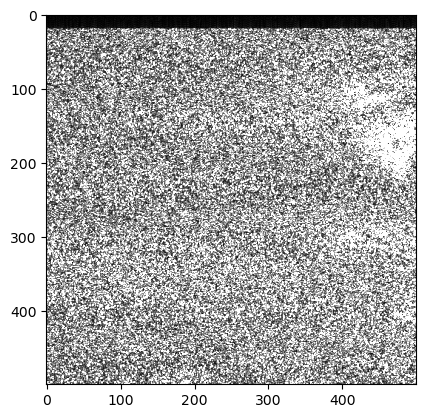

In [87]:
plt.imshow(np.abs(img2),cmap="gray",vmax= 1/11* np.max(np.abs(img2)))
plt.show()

# Forming the ratio image

In [89]:
reference_image=img1
#reference_image = image_1
def ratio(img, reference_img):
    # Ajoutez une petite valeur à reference_img pour éviter la division par zéro
    for i in range (np.shape(reference_img)[0]):
        for j in range (np.shape(reference_img)[1]):
             if reference_img[i, j] == 0.+0.j:
                    reference_img[i, j] = 1e-3+0.j               
    return np.clip(img / reference_image, 1e-3, 10)

ratio_img = ratio (img2, reference_image) 

In [90]:
#interpolation
ratio_nn= list(map(interpolate_nn,tqdm(ratio_img)))

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 18616.20it/s]


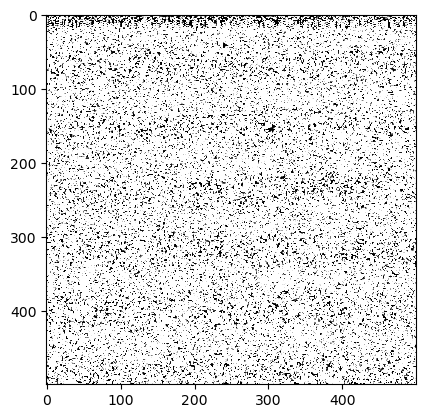

In [92]:
#affichage de l'image ratio: 
plt.imshow(np.abs(ratio_img),cmap="gray",vmax= 1/11* np.max(np.abs(ratio_img)))
plt.show()

# Spatial Despeckling of Ratios

In [113]:
mask_c = np.isnan(img2)
img_c = np.abs(img2)
#img_c = img2
print (img_c)
ref_c = img1
enl_mask = get_enl_mask(img_c, db_min=-13)
enl_img = get_enl_img(img_c, 31, enl_max=20, mask=enl_mask)
L = round(get_enl_mode(enl_img))

# We increase the max because the smoothing of the super image using TV will greatly increase this.
# You could still use the unsmoothed temporal average, too, if the results are not reasonable
enl_img_ta = get_enl_img(ref_c, 31, enl_max=1_000, mask=enl_mask)
Lm = round(get_enl_mode(enl_img_ta))

L, Lm

[[  1.   0.   0. ...   1.   1.   3.]
 [  0.   4.   2. ...   1.   1.   0.]
 [  2.   2.   0. ...   3.   0.   0.]
 ...
 [102.  14. 114. ...  85.  96.  60.]
 [  3.   9.  58. ...  54.  35.  13.]
 [ 62.  19.  61. ...  16.  48.  29.]]


(20, 1)

In [137]:
regularizer_dict = {
                         'weight': .1
                        }
ratio_den, res_list = admm_ratio_denoise(np.abs(ratio_img),
                                         L,
                                         Lm,
                                         'bm3d',
                                         regularizer_dict, 
                                         max_admm_iterations=10,
                                         newton_iterations=3)
ratio_den[mask_c] = np.nan

admm_iterations: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


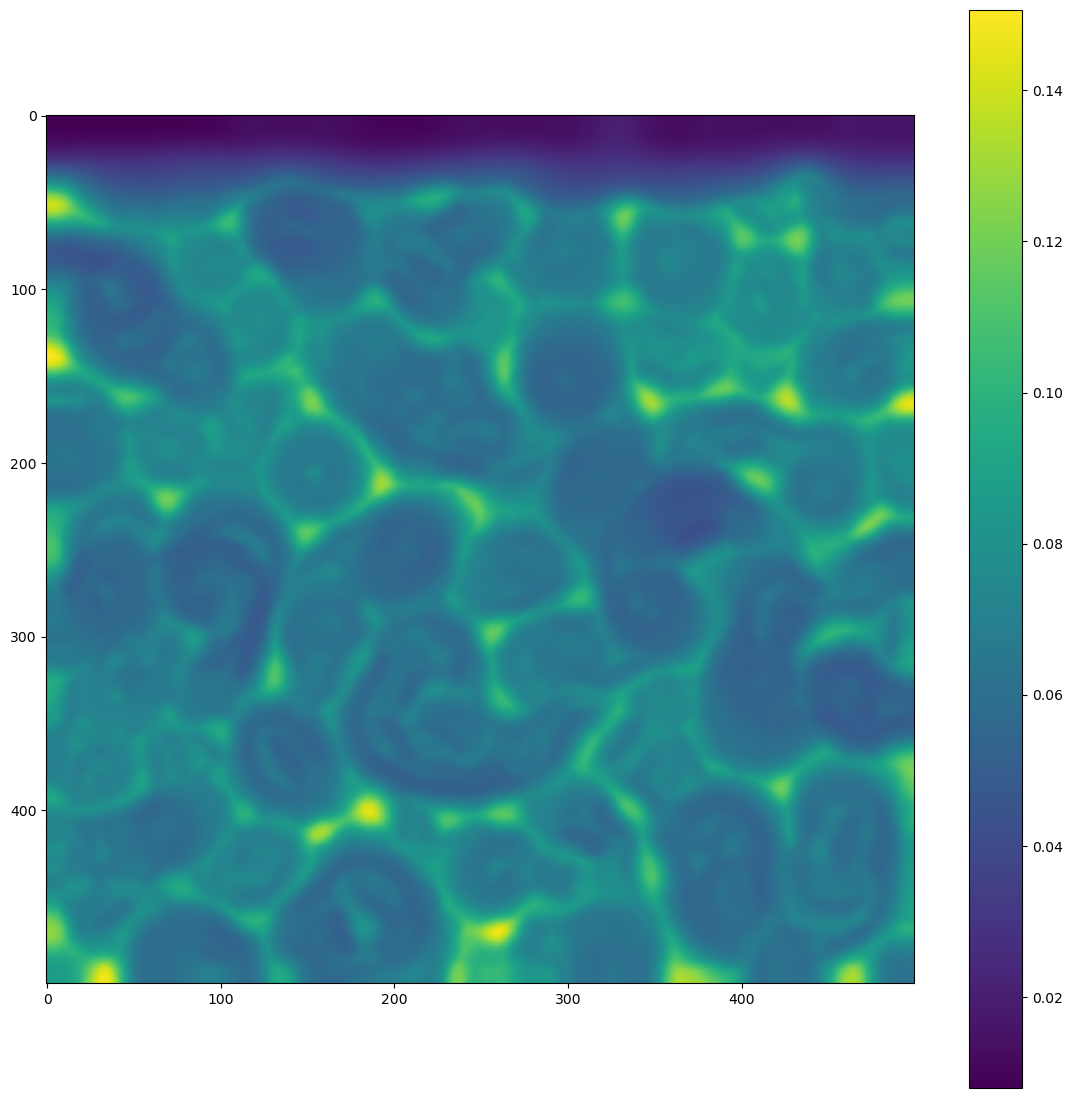

In [138]:
plt.subplots(figsize=(14, 14))
plt.imshow(ratio_den)
plt.colorbar()